In [1]:
import random
import pennylane as qml
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
import mne
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

/global/homes/j/junghoon/.local/perlmutter/python-3.11/lib/python3.11/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.34 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Running on  cuda


# QCNN Model

Cong, I., Choi, S., & Lukin, M. D. (2019). Quantum convolutional neural networks. _Nature Physics_, 15(12), 1273-1278. DOI:10.1038/s41567-019-0648-8
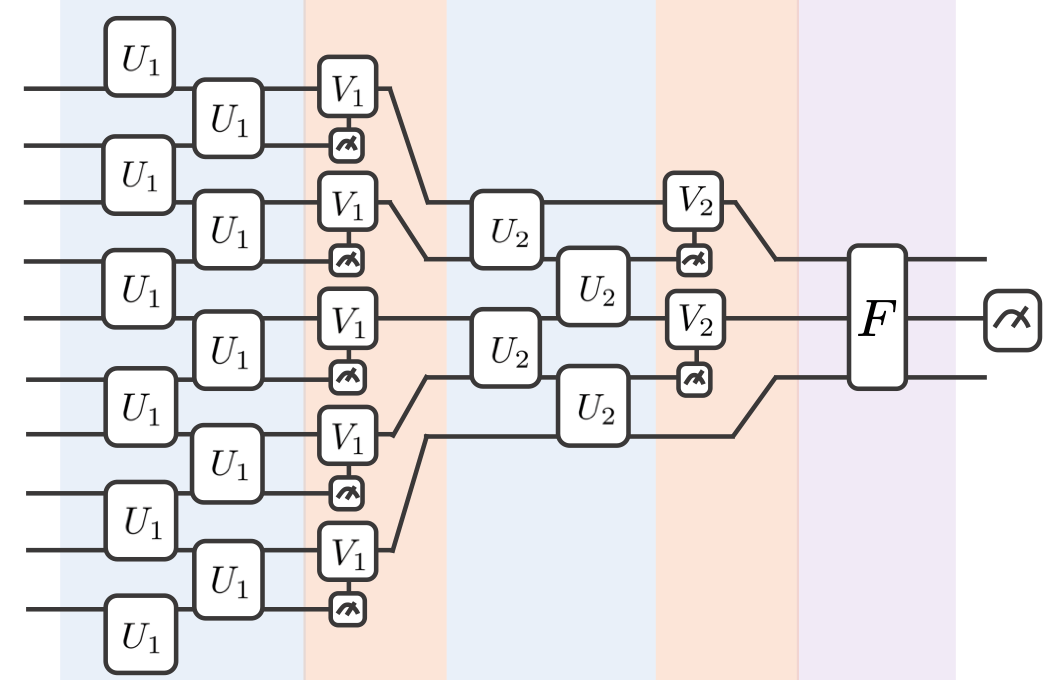

In [2]:
class QCNN(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, input_dim=784, num_classes=10):
        """
        QCNN with classical dimensionality reduction and variational embedding for multi-class classification.

        Args:
            n_qubits (int): Number of qubits.
            n_layers (int): Number of convolutional & pooling layers.
            input_dim (int): Original input data dimensionality (e.g., MNIST image size).
            num_classes (int): Number of classes for classification.
        """
        super(QCNN, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.num_classes = num_classes

        # Classical dimension reduction (fully-connected layer)
        self.fc = nn.Linear(input_dim, n_qubits)
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def circuit(self, conv_weights, pool_weights, features):
        wires = list(range(self.n_qubits))
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.n_layers):
            # Convolutional Layer
            self._apply_convolution(conv_weights[layer], wires)
            # Pooling Layer
            self._apply_pooling(pool_weights[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def forward(self, x):
        # Classical dimension reduction
        reduced_x = self.fc(x)
        # Quantum Circuit Execution
        quantum_out = qml.qnode(self.dev, interface="torch")(self.circuit)(self.conv_params, self.pool_params, reduced_x)
        # Convert quantum output to logits for multi-class classification
        quantum_out = torch.stack(quantum_out, dim=1).float()
        return quantum_out

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

## Circuit Visualization

In [28]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)

In [29]:
# Quantum parameters
conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))

# Quantum device initialization
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(conv_weights, pool_weights, features):
    wires = list(range(n_qubits))
    # Variational Embedding (Angle Embedding)
    qml.AngleEmbedding(features, wires=wires, rotation='Y')
    for layer in range(n_layers):
        # Convolutional Layer
        _apply_convolution(conv_weights[layer], wires)
        # Pooling Layer
        _apply_pooling(pool_weights[layer], wires)
        wires = wires[::2]  # Retain every second qubit after pooling
    # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
    return qml.expval(qml.PauliZ(n_qubits-1))

def _apply_convolution(weights, wires):
    """
    Convolutional layer logic (same as original).
    """
    n_wires = len(wires)
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                qml.U3(*weights[indx, :3], wires=w)
                qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[indx, 9:12], wires=w)
                qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

def _apply_pooling(pool_weights, wires):
    # Pooling using a variational circuit
    n_wires = len(wires)
    assert n_wires >= 2, "Need at least two wires for pooling."
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            measurement = qml.measure(w)
            qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

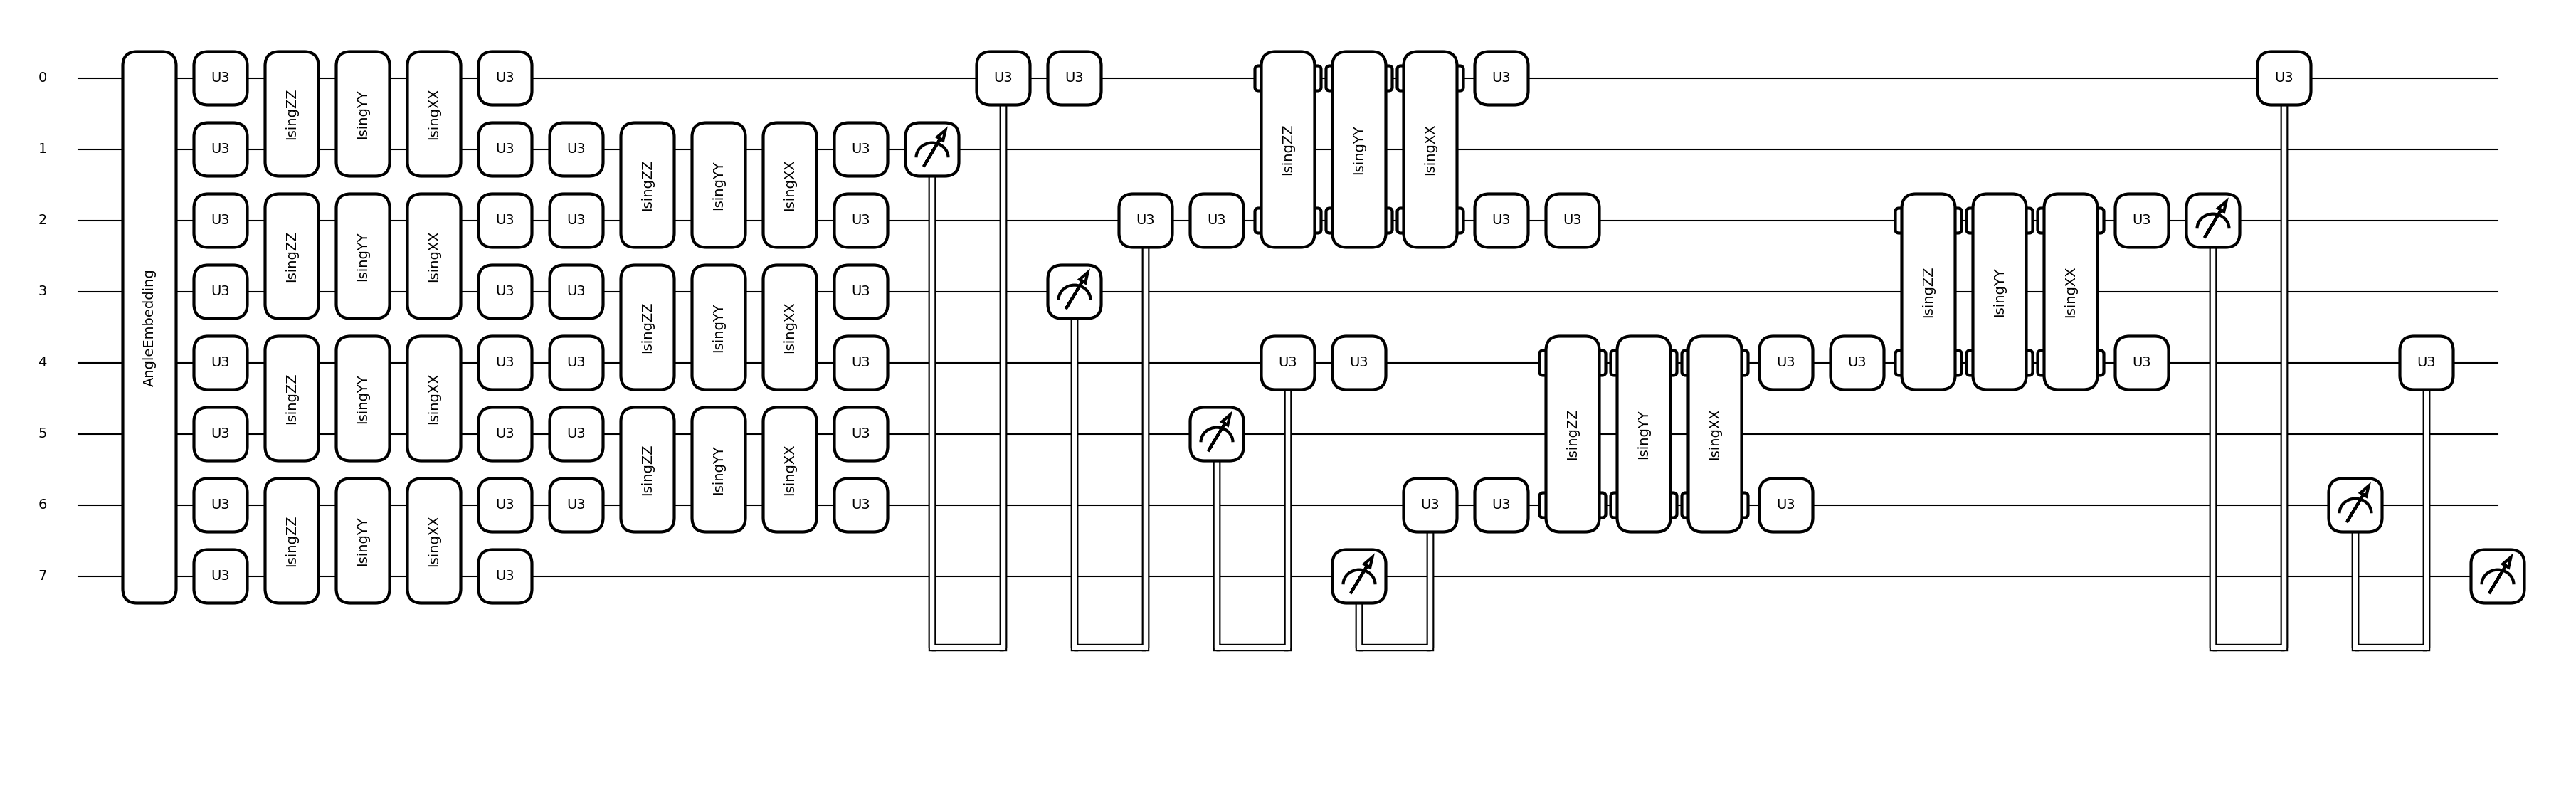

In [30]:
fig, ax = qml.draw_mpl(circuit)(conv_params, pool_params, classical_features)

# Quantum Temporal Convolutional Neural Network

In [2]:
class QTCN(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size, dilation=1):
        super(QTCN, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        # The kernel size defines how many time steps we consider for the "convolution"
        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # The input channels are treated as the feature size for each time step
        # Fully connected classical linear layer
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)  # For dimension reduction
        self.downsample = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        # self.fc_out = nn.Linear(self.time_steps - self.dilation * (self.kernel_size - 1), 1)  # Final output layer for Binary Classification

    def circuit(self, features):
        wires = list(range(self.n_qubits))    
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            # Convolutional Layer
            self._apply_convolution(self.conv_params[layer], wires)
            # Pooling Layer
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Measurement
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."

        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])
                
    def forward(self, x):
        # x has shape (batch_size, time_steps, input_channels)
        batch_size, input_channels, time_steps = x.size()
        # Quantum Circuit Execution
        quantum_circuit = qml.QNode(self.circuit, self.dev)
        # Initialize an empty list to store the output
        output = []
        # Slide a window of size `kernel_size` across the time steps (with dilation)
        for i in range(self.dilation * (self.kernel_size - 1), time_steps):
            indices = [i - d*self.dilation for d in range(self.kernel_size)]
            indices.reverse()
            window = x[:, :, indices].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            residual = x[:, :, -(self.kernel_size):].reshape(batch_size, -1)
            residual = self.downsample(residual)
            output.append(quantum_circuit(reduced_window+residual))
        # output = torch.stack(output, dim=1)
        # output = self.fc_out(output.float()).squeeze(1)
        output = torch.mean(torch.stack(output, dim=1), dim=1)
        return output

# Prepare PhysioNet EEG Dataset

Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. _IEEE Transactions on Biomedical Engineering_ 51(6):1034-1043, 2004.
https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html

In [3]:
def load_eeg_ts(seed, device, batch_size, sampling_freq):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
    # Load and preprocess the PhysioNet EEG Motor Imagery data
    N_SUBJECT = 50
    IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]

    # Load data from PhysioNet (example assumes data is downloaded locally)
    physionet_paths = [
        mne.datasets.eegbci.load_data(
            subjects=subj_id,
            runs=IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
            path="PhysioNet_EEG",
        ) for subj_id in range(1, N_SUBJECT+1)
    ]
    physionet_paths = np.concatenate(physionet_paths)

    # Ensuring that all subjects share same sampling frequency
    # TARGET_SFREQ = 160  # 160 Hz sampling rate
    TARGET_SFREQ = sampling_freq

    # Concatenate all loaded raw data
    parts = []
    for path in physionet_paths:
        raw = mne.io.read_raw_edf(
            path,
            preload=True,
            stim_channel='auto',
            verbose='WARNING',
        )
        # Resample raw data to ensure consistent sfreq
        raw.resample(TARGET_SFREQ, npad="auto")
        parts.append(raw)
        
    # Concatenate resampled raw data
    raw = mne.concatenate_raws(parts)

    # Pick EEG channels and extract events
    eeg_channel_inds = mne.pick_types(
        raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads'
    )
    events, _ = mne.events_from_annotations(raw)

    # Epoch the data
    epoched = mne.Epochs(
        raw, events, dict(left=2, right=3), tmin=1, tmax=4.1,
        proj=False, picks=eeg_channel_inds, baseline=None, preload=True
    )

    # Convert data to NumPy arrays
    X = (epoched.get_data() * 1e3).astype(np.float32)  # Convert to millivolts
    y = (epoched.events[:, 2] - 2).astype(np.int64)  # 0: left, 1: right
    
    # Train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    
    def MakeTensorDataset(X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        tensordataset = TensorDataset(X_tensor, y_tensor)
        return tensordataset
    
    # Create datasets and dataloaders
    train_dataset = MakeTensorDataset(X_train, y_train)
    val_dataset = MakeTensorDataset(X_val, y_val)
    test_dataset = MakeTensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim = X_train.shape
    
    return train_loader, val_loader, test_loader, input_dim

# Train & Evaluation Functions

In [4]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


################################# Performance & Density Matrices ################################
# Training loop
def train_perf(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Collect labels and outputs for AUROC
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())       
        
    # Calculate train AUROC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_auroc = roc_auc_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_auroc


# Validation/Test loop
def evaluate_perf(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    auroc = roc_auc_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), auroc

# Load Dataset

In [5]:
train_loader, val_loader, test_loader, input_dim = load_eeg_ts(seed=2025, device=device, batch_size=32, sampling_freq=80)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
Using data from preloaded Raw for 2250 events and 249 original time points ...
116 bad epochs dropped


In [6]:
input_dim

(1493, 64, 249)

In [7]:
def QuantumTCNN_run(n_qubits, circuit_depth, kernel_size, dilation, num_epochs):
    print("Running on ", device)
    model = QTCN(n_qubits, circuit_depth, input_dim, kernel_size, dilation).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumTCNN_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [8]:
QuantumTCNN_run(n_qubits=8, circuit_depth=2, kernel_size=6, dilation=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [01:20<00:00,  8.07s/it]


Epoch: 01 | Time: 15m 48s
Train Loss: 0.6931, AUC: 0.5060 | Validation Loss: 0.6920, AUC: 0.5711


100%|██████████| 10/10 [01:18<00:00,  7.90s/it]


Epoch: 02 | Time: 15m 31s
Train Loss: 0.6801, AUC: 0.6238 | Validation Loss: 0.6842, AUC: 0.6567


100%|██████████| 10/10 [01:19<00:00,  7.90s/it]


Epoch: 03 | Time: 15m 19s
Train Loss: 0.6443, AUC: 0.7165 | Validation Loss: 0.6800, AUC: 0.6873


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


Epoch: 04 | Time: 15m 6s
Train Loss: 0.6064, AUC: 0.7644 | Validation Loss: 0.6733, AUC: 0.7003


100%|██████████| 10/10 [01:18<00:00,  7.85s/it]


Epoch: 05 | Time: 15m 4s
Train Loss: 0.5872, AUC: 0.7831 | Validation Loss: 0.6660, AUC: 0.7162


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


Epoch: 06 | Time: 15m 4s
Train Loss: 0.5659, AUC: 0.7998 | Validation Loss: 0.6631, AUC: 0.7219


100%|██████████| 10/10 [01:18<00:00,  7.85s/it]


Epoch: 07 | Time: 15m 5s
Train Loss: 0.5546, AUC: 0.8106 | Validation Loss: 0.6565, AUC: 0.7205


100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


Epoch: 08 | Time: 15m 6s
Train Loss: 0.5443, AUC: 0.8148 | Validation Loss: 0.6628, AUC: 0.7146


100%|██████████| 10/10 [01:18<00:00,  7.85s/it]


Epoch: 09 | Time: 15m 7s
Train Loss: 0.5402, AUC: 0.8188 | Validation Loss: 0.6646, AUC: 0.7107


100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


Epoch: 10 | Time: 15m 5s
Train Loss: 0.5269, AUC: 0.8271 | Validation Loss: 0.6677, AUC: 0.7075


100%|██████████| 11/11 [01:26<00:00,  7.85s/it]

Test Loss: 0.5316, AUC: 0.7706
Metrics saved to QuantumTCNN_performance.csv


(0.5316384509205818, 0.7705603788476717)

# Classical CNN

In [9]:
class TemporalLinearCNN(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, dilation=1):
        super(TemporalLinearCNN, self).__init__()
        
        # The kernel size defines how many time steps we consider for the "convolution"
        self.kernel_size = kernel_size
        self.dilation = dilation       
        # The input channels are treated as the feature size for each time step
        # We will apply a linear transformation on a "window" of time steps
        self.fc1 = nn.Linear(input_channels * kernel_size, output_channels)
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        # Fully connected output layer
        self.fc2 = nn.Linear(64, output_channels)  # For binary classification

    def forward(self, x):
        # x has shape (batch_size, time_steps, input_channels)
        batch_size, time_steps, input_channels = x.size()
        # Initialize an empty list to store the output
        output = []
        # Slide a window of size `kernel_size` across the time steps (with dilation)
        for i in range(self.dilation * (self.kernel_size - 1), time_steps):
            indices = [i - d*self.dilation for d in reversed(range(self.kernel_size))]
            window = x[:, indices, :].reshape(batch_size, -1)
            output.append(self.fc1(window))  # Apply the linear transformation to the window
        # Stack the results back into a tensor with shape (batch_size, output_time_steps, output_channels)
        x = torch.stack(output, dim=1)
        x = torch.relu(x)
        x = self.global_pool(x.permute(0, 2, 1))  # Switch batch and time dimensions for pooling
        # Flatten the tensor and pass through the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten
        final_output = self.fc2(x)
        
        return final_output

In [10]:
def ClassicalCNN_run(n_qubits, circuit_depth, num_epochs):
    print("Running on ", device)
    model = ClassicalCNN(n_qubits, circuit_depth, input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"ClassicalCNN_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [11]:
ClassicalCNN_run(n_qubits=12, circuit_depth=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch: 01 | Time: 0m 0s
Train Loss: 0.6869, AUC: 0.6186 | Validation Loss: 0.6759, AUC: 0.7196


100%|██████████| 10/10 [00:00<00:00, 1588.69it/s]


Epoch: 02 | Time: 0m 0s
Train Loss: 0.6599, AUC: 0.7275 | Validation Loss: 0.6459, AUC: 0.7520


100%|██████████| 10/10 [00:00<00:00, 1694.67it/s]


Epoch: 03 | Time: 0m 0s
Train Loss: 0.6129, AUC: 0.7874 | Validation Loss: 0.5939, AUC: 0.8233


100%|██████████| 10/10 [00:00<00:00, 1674.57it/s]


Epoch: 04 | Time: 0m 0s
Train Loss: 0.5647, AUC: 0.8331 | Validation Loss: 0.5601, AUC: 0.8389


100%|██████████| 10/10 [00:00<00:00, 1708.75it/s]


Epoch: 05 | Time: 0m 0s
Train Loss: 0.5414, AUC: 0.8439 | Validation Loss: 0.5438, AUC: 0.8272


100%|██████████| 10/10 [00:00<00:00, 1680.41it/s]


Epoch: 06 | Time: 0m 0s
Train Loss: 0.5317, AUC: 0.8432 | Validation Loss: 0.5465, AUC: 0.8212


100%|██████████| 10/10 [00:00<00:00, 1712.38it/s]


Epoch: 07 | Time: 0m 0s
Train Loss: 0.5015, AUC: 0.8593 | Validation Loss: 0.5378, AUC: 0.8238


100%|██████████| 10/10 [00:00<00:00, 1724.21it/s]


Epoch: 08 | Time: 0m 0s
Train Loss: 0.4857, AUC: 0.8624 | Validation Loss: 0.5257, AUC: 0.8223


100%|██████████| 10/10 [00:00<00:00, 1720.88it/s]


Epoch: 09 | Time: 0m 0s
Train Loss: 0.4694, AUC: 0.8682 | Validation Loss: 0.5208, AUC: 0.8240


100%|██████████| 10/10 [00:00<00:00, 1750.76it/s]


Epoch: 10 | Time: 0m 0s
Train Loss: 0.4626, AUC: 0.8615 | Validation Loss: 0.5792, AUC: 0.8051


100%|██████████| 10/10 [00:00<00:00, 1647.86it/s]

Test Loss: 0.5565, AUC: 0.8413
Metrics saved to ClassicalCNN_performance.csv


(0.5564588636159897, 0.8412851019508873)